In [88]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.48 PM (1).jpeg
/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.48 PM.jpeg
/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.49 PM.jpeg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_15.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_20.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_26.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_14.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_19.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_33.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_8.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_5.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_10.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_21.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_7.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_27.jpg
/kaggle/input/dry-plants-healthy-plants

In [89]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import pandas as pd



In [90]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8

In [91]:
# Directory containing images of cats and dogs
Healthy_dir = "/kaggle/input/dry-plants-healthy-plants/Healthy plants"
dry_dir = "/kaggle/input/dry-plants-healthy-plants/dry plants"


In [92]:
# Get list of cat and dog image files
Healthy_files = [os.path.join(Healthy_dir, filename) for filename in os.listdir(Healthy_dir)]
dry_files = [os.path.join(dry_dir, filename) for filename in os.listdir(dry_dir)]

In [93]:
# Create labels for cats (0) and dogs (1)
Healthy_labels = np.zeros(len(Healthy_files))
dry_labels = np.ones(len(dry_files))


In [94]:
# Concatenate file paths and labels
file_paths = Healthy_files + dry_files
labels = np.concatenate([Healthy_labels, dry_labels])

# Create DataFrame
df = pd.DataFrame({"Filepath": file_paths, "Label": labels})

# Shuffle DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split DataFrame into training and validation sets
train_df = df.iloc[:int(0.8*len(df))]
val_df = df.iloc[int(0.8*len(df)):]


In [95]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [96]:
# Create DataFrame with labels as strings
df = pd.DataFrame({"Filepath": file_paths, "Label": labels.astype(str)})

# Shuffle DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split DataFrame into training and validation sets
train_df = df.iloc[:int(0.8*len(df))]
val_df = df.iloc[int(0.8*len(df)):]

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 56 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.


In [101]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')


In [102]:
# Freeze base layers
base_model.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


In [103]:
# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - accuracy: 0.5314 - loss: 1.1169 - val_accuracy: 0.7143 - val_loss: 0.5352
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.8263 - loss: 0.3548 - val_accuracy: 0.9286 - val_loss: 0.2676
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.8446 - loss: 0.2885 - val_accuracy: 0.7857 - val_loss: 0.3332
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.9573 - loss: 0.1343 - val_accuracy: 0.8571 - val_loss: 0.2328
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.9666 - loss: 0.1043 - val_accuracy: 0.7857 - val_loss: 0.2783
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 1.0000 - loss: 0.0481 - val_accuracy: 0.8571 - val_loss: 0.2262
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.9859 - loss: 0.0833 - val_accuracy: 0.9286 - val_loss: 0.2274
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 1.0000 - loss: 0.0452 - val_accuracy: 0.7143 - val_loss:

In [104]:

# Evaluate model
test_loss, test_acc = model.evaluate(val_generator)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8214 - loss: 0.3105
Test Accuracy: 0.8571428656578064


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted label: Healthy


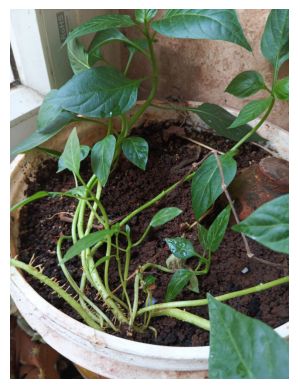

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image



# Preprocess the new images
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values
    return img_array

# Example usage
img_path = "/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.48 PM.jpeg"
img_array = preprocess_image(img_path, target_size=(224, 224))

# Predict the label of the new image
prediction = model.predict(img_array)

# Decode the prediction
predicted_label = "Dry" if prediction > 0.5 else "Healthy"
print("Predicted label:", predicted_label)

# Display the image
img = image.load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()
